In [1]:
import os, itertools
from PIL import Image

from torchvision import transforms, datasets
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import shutil
import random
import copy
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from datetime import datetime

In [2]:
path = os.path.join(os.getcwd(), 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder')

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_3652\292660229.py:1: SyntaxWarning: invalid escape sequence '\M'
  path = os.path.join(os.getcwd(), 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder')


In [3]:
obj_dt = datasets.ImageFolder(path, transform=transforms.ToTensor())
dataloader = DataLoader(obj_dt, batch_size=64, shuffle=True, num_workers=4)

In [4]:
mean = torch.zeros(3)
std = torch.zeros(3)

In [5]:
for images, _ in dataloader :
    for d in range(3) :
        mean[d] += images[:, d, :, :].mean()
        std[d] += images[:, d, :, :].std()

mean.div_(len(obj_dt))
std.div_(len(obj_dt))

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.0091, 0.0094, 0.0080])
Std: tensor([0.0048, 0.0047, 0.0056])


In [6]:
data_transform = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'val' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}

In [7]:
directory = os.path.join(os.getcwd(), 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder')

img_dt ={
    'train' : datasets.ImageFolder(os.path.join(directory, 'train'), transform=data_transform['train']),
    'test' : datasets.ImageFolder(os.path.join(directory, 'test'), transform=data_transform['test']),
    'val' : datasets.ImageFolder(os.path.join(directory, 'val'), transform=data_transform['val']),
}

dataloaders = {
    'train' : DataLoader(img_dt['train'], batch_size=16, shuffle=True, num_workers=4),
    'test' : DataLoader(img_dt['test'], batch_size=16, shuffle=True, num_workers=4),
    'val' : DataLoader(img_dt['val'], batch_size=16, shuffle=True, num_workers=4),
}

dt_sizes = {x: len(img_dt[x]) for x in ['train', 'test', 'val']}
class_names = img_dt['train'].classes

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_3652\1545498021.py:1: SyntaxWarning: invalid escape sequence '\M'
  directory = os.path.join(os.getcwd(), 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder')


## Modelling Code

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
class EarlyStopping :
    def __init__(self, patience=7, min_delta=0) :
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_loss, model) :
        if self.best_loss is None :
            self.best_loss = val_loss
            self.best_state = copy.deepcopy(model.state_dict())

        elif val_loss > self.best_loss + self.min_delta :
            self.counter += 1
            if self.counter >= self.patience :
                self.early_stop = True
                
        else :
            self.best_loss = val_loss
            self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        
        return False

In [10]:
def create_model(num_classes, dropout):
    model = models.alexnet(pretrained = True)

    for param in model.parameters() :
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Dropout(p=dropout),
        nn.Linear(1024, num_classes),
    )

    return model

In [11]:
def get_class_weights(dataset) :
    labels = []

    for _, label in dataset :
        labels.append(label)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    
    return torch.FloatTensor(class_weights)

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
optimizers = ['SGD', 'Adam']
# batch_Sizes = [16, 32]
dropout_rates = [0.5, 0.6]

In [13]:
best_model = None
best_acc = 0.0
best_params = {}

In [14]:
def train_model(model, criterion, scheduler, optimizer, num_epochs):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 5
    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dt_sizes[phase]
            epoch_acc = running_corrects.double() / dt_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else :
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f'{phase} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if early_stopping(epoch_loss, model):
                    print('Early stopping')
                    model.load_state_dict(early_stopping.best_state)
                    return model
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs
    

In [15]:
for lr, opt_name, drop in itertools.product(learning_rates, optimizers, dropout_rates) :
    print(f"\n=== Training with Lr={lr}, Optimizer={opt_name}, Dropout={drop} ===")

    model = create_model(num_classes=5, dropout=drop)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    if opt_name == 'Adam' :
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else :
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

    trained_model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, scheduler, optimizer, num_epochs = 10)

    final_val_acc = val_accs[-1]
    print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
    
    model_filename = f"model_lr{lr}_opt{opt_name}_drop{drop}_acc{final_val_acc:.4f}.pth"

    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'optimizer': opt_name,
        'learning_rate': lr,
        'dropout': drop,
        'val_accuracy': final_val_acc
    }, model_filename)

    print(f"Saved model to {model_filename}")


    if final_val_acc > best_acc :
        best_acc = final_val_acc
        best_model = trained_model
        best_params = {
            'learning_rate' : lr,
            'optimizer' : opt_name,
            'dropout_rate' : drop,
        }

print(f"Best Model: {best_model}")
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_acc:.4f}")


=== Training with Lr=0.01, Optimizer=SGD, Dropout=0.5 ===


c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
----------
train Loss : 2.8966 Acc : 0.3419
val Loss : 1.7497 Acc : 0.4412
Epoch 2/10
----------
train Loss : 3.6876 Acc : 0.4375
val Loss : 4.2033 Acc : 0.2941
Epoch 3/10
----------
train Loss : 4.6965 Acc : 0.4412
val Loss : 1.3084 Acc : 0.6471
Epoch 4/10
----------
train Loss : 4.4853 Acc : 0.5110
val Loss : 1.5424 Acc : 0.6471
Epoch 5/10
----------
train Loss : 3.6433 Acc : 0.5515
val Loss : 1.8322 Acc : 0.5588
Epoch 6/10
----------
train Loss : 3.9091 Acc : 0.5680
val Loss : 2.5383 Acc : 0.7059
Epoch 7/10
----------
train Loss : 3.7923 Acc : 0.5846
val Loss : 1.4617 Acc : 0.6176
Epoch 8/10
----------
train Loss : 2.9034 Acc : 0.6213
val Loss : 0.8542 Acc : 0.7059
Epoch 9/10
----------
train Loss : 2.1417 Acc : 0.6599
val Loss : 0.6965 Acc : 0.7647
Epoch 10/10
----------
train Loss : 2.3179 Acc : 0.6507
val Loss : 0.6577 Acc : 0.7353
Best val acc: 0.764706

Final Validation Accuracy: 0.7353
Saved model to model_lr0.01_optSGD_drop0.5_acc0.7353.pth

=== Training with Lr=0.

## Best Model Testing

In [16]:
checkpoint = torch.load('model_lr0.001_optAdam_drop0.5_acc0.8529.pth')
print(checkpoint.keys())

dict_keys(['model_state_dict', 'optimizer', 'learning_rate', 'dropout', 'val_accuracy'])


In [17]:
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.6, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
correct = 0
total = 0

all_labels = []
predictions = []

In [19]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Total data to test : ' + str(total))
print(f'Total data correct : ' + str(correct))
print(f'Accuracy : {accuracy:.2f}%')

Total data to test : 34
Total data correct : 31
Accuracy : 91.18%


In [20]:
print(classification_report(all_labels, predictions, target_names=img_dt['test'].classes))

                 precision    recall  f1-score   support

    bercak_daun       0.86      0.86      0.86         7
  daun_berkerut       0.92      1.00      0.96        11
  daun_berputar       0.83      1.00      0.91         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.71      0.83         7

       accuracy                           0.91        34
      macro avg       0.92      0.91      0.91        34
   weighted avg       0.92      0.91      0.91        34



## All Models Testing

In [22]:
models_dir = 'batch_16_models'
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]

In [23]:
results = []

In [24]:
conf_matrices = []

In [25]:
for model_file in model_files :
    print(f"\n ================== Testing model {model_file}... ================== \n")

    checkpoint = torch.load(os.path.join(models_dir, model_file), map_location=device)

    model = create_model(num_classes=5, dropout=checkpoint['dropout'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Total data to test : ' + str(total))
    print(f'Total data correct : ' + str(correct))
    print(f'Accuracy : {accuracy:.2f}%')

    print(classification_report(all_labels, predictions, target_names=img_dt['test'].classes))

    results.append({
        'model_name' : model_file,
        'accuracy' : accuracy,
    })

    cm = confusion_matrix(all_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=img_dt['test'].classes)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.title(f"Confusion Matrix for {model_file}")
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"confusion_matrix_{model_file}.png")
    plt.close()

results.sort(key=lambda x: x['accuracy'], reverse=True)

print("\n\n ================== Results of all models ================== \n")
for result in results :
    print(f"Model: {result['model_name']}, Accuracy: {result['accuracy']:.2f}%")


 ================== Testing model model_lr0.0001_optAdam_drop0.5_acc0.7941.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 31
Accuracy : 91.18%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       0.85      1.00      0.92        11
  daun_berputar       0.83      1.00      0.91         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.86      0.92         7

       accuracy                           0.91        34
      macro avg       0.94      0.91      0.92        34
   weighted avg       0.93      0.91      0.91        34


 ================== Testing model model_lr0.0001_optAdam_drop0.6_acc0.7059.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 28
Accuracy : 82.35%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       0.73      1.00      0.85        11
  daun_berputar       0.80      0.80      0.80         5
daun_menggulung       0.80      1.00      0.89         4
 daun_menguning       1.00      0.57      0.73         7

       accuracy                           0.82        34
      macro avg       0.87      0.82      0.82        34
   weighted avg       0.86      0.82      0.82        34


 ================== Testing model model_lr0.0001_optSGD_drop0.5_acc0.5882.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 26
Accuracy : 76.47%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.43      0.60         7
  daun_berkerut       0.83      0.91      0.87        11
  daun_berputar       1.00      0.80      0.89         5
daun_menggulung       0.50      1.00      0.67         4
 daun_menguning       0.71      0.71      0.71         7

       accuracy                           0.76        34
      macro avg       0.81      0.77      0.75        34
   weighted avg       0.83      0.76      0.76        34


 ================== Testing model model_lr0.0001_optSGD_drop0.6_acc0.5294.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 26
Accuracy : 76.47%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.29      0.44         7
  daun_berkerut       0.73      1.00      0.85        11
  daun_berputar       1.00      0.80      0.89         5
daun_menggulung       0.67      1.00      0.80         4
 daun_menguning       0.71      0.71      0.71         7

       accuracy                           0.76        34
      macro avg       0.82      0.76      0.74        34
   weighted avg       0.82      0.76      0.74        34


 ================== Testing model model_lr0.001_optAdam_drop0.5_acc0.8529.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 31
Accuracy : 91.18%
                 precision    recall  f1-score   support

    bercak_daun       0.86      0.86      0.86         7
  daun_berkerut       0.92      1.00      0.96        11
  daun_berputar       0.83      1.00      0.91         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.71      0.83         7

       accuracy                           0.91        34
      macro avg       0.92      0.91      0.91        34
   weighted avg       0.92      0.91      0.91        34


 ================== Testing model model_lr0.001_optAdam_drop0.6_acc0.8529.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 32
Accuracy : 94.12%
                 precision    recall  f1-score   support

    bercak_daun       0.86      0.86      0.86         7
  daun_berkerut       0.92      1.00      0.96        11
  daun_berputar       1.00      1.00      1.00         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.86      0.92         7

       accuracy                           0.94        34
      macro avg       0.95      0.94      0.95        34
   weighted avg       0.94      0.94      0.94        34


 ================== Testing model model_lr0.001_optSGD_drop0.5_acc0.8235.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 28
Accuracy : 82.35%
                 precision    recall  f1-score   support

    bercak_daun       0.67      0.57      0.62         7
  daun_berkerut       0.90      0.82      0.86        11
  daun_berputar       1.00      0.80      0.89         5
daun_menggulung       0.67      1.00      0.80         4
 daun_menguning       0.88      1.00      0.93         7

       accuracy                           0.82        34
      macro avg       0.82      0.84      0.82        34
   weighted avg       0.83      0.82      0.82        34


 ================== Testing model model_lr0.001_optSGD_drop0.6_acc0.6765.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 29
Accuracy : 85.29%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       1.00      1.00      1.00        11
  daun_berputar       0.67      0.80      0.73         5
daun_menggulung       0.57      1.00      0.73         4
 daun_menguning       1.00      0.71      0.83         7

       accuracy                           0.85        34
      macro avg       0.85      0.85      0.82        34
   weighted avg       0.90      0.85      0.86        34


 ================== Testing model model_lr0.01_optAdam_drop0.5_acc0.7941.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 28
Accuracy : 82.35%
                 precision    recall  f1-score   support

    bercak_daun       0.67      0.86      0.75         7
  daun_berkerut       0.91      0.91      0.91        11
  daun_berputar       0.67      0.80      0.73         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.57      0.73         7

       accuracy                           0.82        34
      macro avg       0.85      0.83      0.82        34
   weighted avg       0.85      0.82      0.82        34


 ================== Testing model model_lr0.01_optAdam_drop0.6_acc0.7353.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 28
Accuracy : 82.35%
                 precision    recall  f1-score   support

    bercak_daun       0.75      0.43      0.55         7
  daun_berkerut       0.92      1.00      0.96        11
  daun_berputar       0.80      0.80      0.80         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       0.67      0.86      0.75         7

       accuracy                           0.82        34
      macro avg       0.83      0.82      0.81        34
   weighted avg       0.82      0.82      0.81        34


 ================== Testing model model_lr0.01_optSGD_drop0.5_acc0.7353.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 30
Accuracy : 88.24%
                 precision    recall  f1-score   support

    bercak_daun       1.00      0.71      0.83         7
  daun_berkerut       0.83      0.91      0.87        11
  daun_berputar       0.71      1.00      0.83         5
daun_menggulung       1.00      1.00      1.00         4
 daun_menguning       1.00      0.86      0.92         7

       accuracy                           0.88        34
      macro avg       0.91      0.90      0.89        34
   weighted avg       0.90      0.88      0.88        34


 ================== Testing model model_lr0.01_optSGD_drop0.6_acc0.7059.pth... ================== 



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total data to test : 34
Total data correct : 25
Accuracy : 73.53%
                 precision    recall  f1-score   support

    bercak_daun       0.62      0.71      0.67         7
  daun_berkerut       0.75      0.82      0.78        11
  daun_berputar       0.80      0.80      0.80         5
daun_menggulung       1.00      0.75      0.86         4
 daun_menguning       0.67      0.57      0.62         7

       accuracy                           0.74        34
      macro avg       0.77      0.73      0.74        34
   weighted avg       0.74      0.74      0.74        34



 ================== Results of all models ================== 

Model: model_lr0.001_optAdam_drop0.6_acc0.8529.pth, Accuracy: 94.12%
Model: model_lr0.0001_optAdam_drop0.5_acc0.7941.pth, Accuracy: 91.18%
Model: model_lr0.001_optAdam_drop0.5_acc0.8529.pth, Accuracy: 91.18%
Model: model_lr0.01_optSGD_drop0.5_acc0.7353.pth, Accuracy: 88.24%
Model: model_lr0.001_optSGD_drop0.6_acc0.6765.pth, Accuracy: 85.29%
Model: mod

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

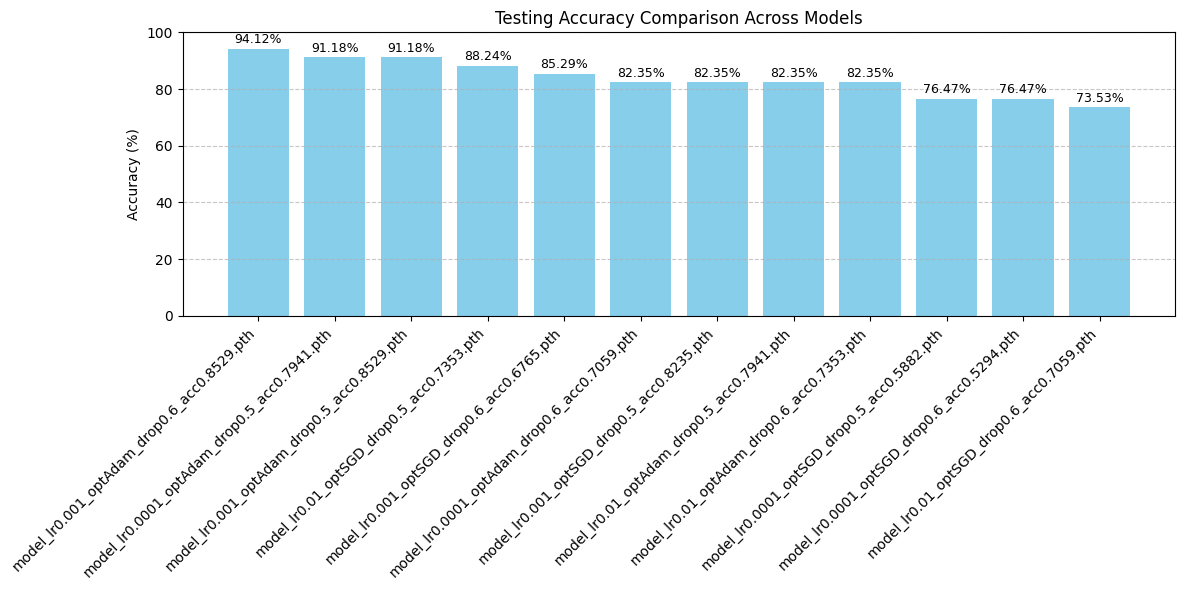

In [26]:
model_names = [res['model_name'] for res in results]
accuracies = [res['accuracy'] for res in results]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Testing Accuracy Comparison Across Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{acc:.2f}%', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
